# **Hard Clustering: Análisis de Patrones de Movimiento con K-Means 📊**

<span style="font-size: 1.5rem;">

🎓 **Universidad:** Fundación Universitaria Konrad Lorenz

</span>

<span style="font-size: 1.25rem;">

🏫 **Facultad:** Facultad de Matemáticas e Ingenierías

📖 **Curso:** Introducción a Big Data

</span>

<span style="font-size: 1.5rem;">

**🧑‍💻 Integrantes:**

</span>

- Ángel Stiven Pinzón Sánchez - 506221100
- Andrea Valentina Cubillos Pinto - 506231711
- Martín Alexander Ramos Yampufe - 506251051


## **1. Introducción**


**El Reconocimiento de Actividad Humana (HAR)** es una técnica ampliamente
utilizada en el monitoreo de la salud, el análisis del rendimiento deportivo y
el seguimiento de la actividad física mediante dispositivos portátiles. Estos
sistemas suelen basarse en datos obtenidos de acelerómetros y giroscopios, los
cuales permiten detectar patrones de movimiento y clasificar actividades.

Uno de los principales desafíos en HAR es la detección de inactividad prolongada
en condiciones de vida libre, un aspecto clave para la prevención de
enfermedades asociadas al sedentarismo. Sin embargo, la mayoría de los estudios
actuales dependen de modelos supervisados, los cuales requieren datos
etiquetados, lo que puede ser un proceso costoso y propenso a errores.

Para abordar esta limitación, en este proyecto aplicaremos K-Means, un algoritmo
de aprendizaje no supervisado, para analizar datos de acelerómetros y detectar
segmentos de tiempo con baja actividad física. Este enfoque nos permitirá
identificar patrones de inactividad sin necesidad de etiquetas previas,
facilitando su aplicación en el monitoreo de la salud y la detección temprana de
conductas sedentarias.


## **2. Objetivos**


El objetivo de este análisis es identificar patrones de movimiento a partir de
datos de acelerómetros, explorando relaciones entre variables y reduciendo la
dimensionalidad de los datos para facilitar su agrupamiento mediante
**K-Means**. Esto permitirá detectar segmentos de baja actividad física y
evaluar su utilidad en el Reconocimiento de Actividad Humana (HAR) para prevenir
enfermedades relacionadas con el sedentarismo.


## **3. Preprocesamiento de datos**


In [1]:
import io
import math
import zipfile
from inspect import cleandoc
from pathlib import Path
from typing import Final

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import requests
import seaborn as sns
from IPython.display import Markdown
from scipy import stats
from scipy.stats import zscore
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    silhouette_score,
)
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [2]:
dataset_url: Final[str] = (
    "https://drive.usercontent.google.com/download?id=1pawtHobYPmvHLKKJfbg12fqkMdG5rlkL&export=download&authuser=0&confirm=t&uuid=c5110138-278c-4dc3-9be0-a11aeaefd54d&at=ALoNOgn9aAhEQRUpJf90DRNzLwiP%3A1748493341099"
)

In [3]:
response = requests.get(
    dataset_url,
    timeout=10,
)

# Delete the data directory if it already exists
data_dir = Path("./data")


def remove_file_or_directory(file_or_directory: Path) -> None:
    """Elimina un archivo o carpeta de forma recursiva."""
    if file_or_directory.is_dir():
        for file in file_or_directory.iterdir():
            remove_file_or_directory(file)
        file_or_directory.rmdir()
    else:
        file_or_directory.unlink()


if data_dir.exists():
    remove_file_or_directory(data_dir)


with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall("./data")

In [4]:
path = Path("./data/harth")
all_files = path.glob("S0*.csv")

df_list = []
for file in all_files:
    temp_df = pl.read_csv(file)

    # Eliminamos la columna 'Unnamed: 0' si existe y index
    if "index" in temp_df.columns:
        temp_df = temp_df.drop("index")
    if "" in temp_df.columns:
        temp_df = temp_df.drop("")

    display(
        Markdown(f"Archivo: {file}, Tamaño: {temp_df.shape}")
    )  # Imprime el tamaño de cada archivo
    df_list.append(temp_df)

display(
    Markdown(
        f"Número total de filas en todos los archivos: {sum(df.shape[0] for df in df_list)}"
    )
)

# Combina los DataFrames
df: pl.DataFrame = pl.concat(
    df_list,
)

# Convierte la columna timestamp a tipo datetime
df = df.with_columns(
    pl.col("timestamp").str.strptime(
        pl.Datetime, "%Y-%m-%d %H:%M:%S%.f", strict=False
    )
)

# Verifica el contenido del DataFrame después de cargar los archivos
display(
    Markdown("Contenido del DataFrame después de cargar los archivos:"),
    df.head(),
    df.describe(),
    df.schema.to_frame(),
    Markdown(f"{df.estimated_size() / (1024 * 1024):.2f} MB"),
)

Archivo: data\harth\S006.csv, Tamaño: (408709, 8)

Archivo: data\harth\S008.csv, Tamaño: (418989, 8)

Archivo: data\harth\S009.csv, Tamaño: (154464, 8)

Archivo: data\harth\S010.csv, Tamaño: (351649, 8)

Archivo: data\harth\S012.csv, Tamaño: (382414, 8)

Archivo: data\harth\S013.csv, Tamaño: (369077, 8)

Archivo: data\harth\S014.csv, Tamaño: (366487, 8)

Archivo: data\harth\S015.csv, Tamaño: (418392, 8)

Archivo: data\harth\S016.csv, Tamaño: (355418, 8)

Archivo: data\harth\S017.csv, Tamaño: (366609, 8)

Archivo: data\harth\S018.csv, Tamaño: (322271, 8)

Archivo: data\harth\S019.csv, Tamaño: (297945, 8)

Archivo: data\harth\S020.csv, Tamaño: (371496, 8)

Archivo: data\harth\S021.csv, Tamaño: (302247, 8)

Archivo: data\harth\S022.csv, Tamaño: (337602, 8)

Archivo: data\harth\S023.csv, Tamaño: (137646, 8)

Archivo: data\harth\S024.csv, Tamaño: (170534, 8)

Archivo: data\harth\S025.csv, Tamaño: (231729, 8)

Archivo: data\harth\S026.csv, Tamaño: (195172, 8)

Archivo: data\harth\S027.csv, Tamaño: (158584, 8)

Archivo: data\harth\S028.csv, Tamaño: (165178, 8)

Archivo: data\harth\S029.csv, Tamaño: (178716, 8)

Número total de filas en todos los archivos: 6461328

Contenido del DataFrame después de cargar los archivos:

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64
2019-01-12 00:00:00,-0.760242,0.29957,0.46857,-5.092732,-0.298644,0.709439,6
2019-01-12 00:00:00.010,-0.530138,0.28188,0.319987,0.900547,0.286944,0.340309,6
2019-01-12 00:00:00.020,-1.170922,0.186353,-0.16701,-0.035442,-0.078423,-0.515212,6
2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.22114,6
2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6


statistic,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""6461328""",6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2012-02-20 18:20:58.805005""",-0.884957,-0.013261,-0.169378,-0.594888,0.020877,0.374916,6.783833
"""std""",null,0.377592,0.231171,0.364738,0.626347,0.388451,0.736098,11.432381
"""min""","""2000-01-01 00:00:00""",-8.0,-4.307617,-6.574463,-8.0,-7.997314,-8.0,1.0
"""25%""","""2000-01-01 01:23:47.680000""",-1.002393,-0.083129,-0.37207,-0.974211,-0.100087,-0.155714,3.0
"""50%""","""2019-01-12 00:12:46.760000""",-0.9749,0.002594,-0.137451,-0.421731,0.032629,0.700439,7.0
"""75%""","""2019-01-12 00:49:20.500000""",-0.812303,0.07251,0.046473,-0.167876,0.154951,0.948675,7.0
"""max""","""2019-01-12 02:23:36.720000""",2.291708,6.491943,4.909483,7.999756,7.999756,8.406235,140.0


timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64


394.37 MB

In [5]:
display(Markdown("Número de valores nulos en cada columna:"), df.null_count())

Número de valores nulos en cada columna:

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0


In [6]:
display(Markdown(f"Tamaño antes de eliminar nulos: {df.shape}"))

df = df.drop_nulls()  # Eliminar filas con valores nulos

Markdown(f"Tamaño después de eliminar nulos: {df.shape}")

Tamaño antes de eliminar nulos: (6461328, 8)

Tamaño después de eliminar nulos: (6461328, 8)

In [7]:
quantitative_cols = [
    "back_x",
    "back_y",
    "back_z",
    "thigh_x",
    "thigh_y",
    "thigh_z",
]

display(
    Markdown(
        cleandoc(f"""
            Tamaño del DataFrame antes de la normalización: {df.shape}

            Contenido del DataFrame antes de la normalización:
        """),
    ),
    df.head(),
)

# Normalización
if all(col in df.columns for col in quantitative_cols):
    if df[quantitative_cols].shape[0] > 0:
        scaler = StandardScaler()
        df[quantitative_cols] = scaler.fit_transform(
            df[quantitative_cols].to_arrow()
        )
    else:
        display(Markdown("Las columnas seleccionadas están vacías."))
else:
    display(Markdown("Una o más columnas no existen en el DataFrame."))

Tamaño del DataFrame antes de la normalización: (6461328, 8)

Contenido del DataFrame antes de la normalización:

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64
2019-01-12 00:00:00,-0.760242,0.29957,0.46857,-5.092732,-0.298644,0.709439,6
2019-01-12 00:00:00.010,-0.530138,0.28188,0.319987,0.900547,0.286944,0.340309,6
2019-01-12 00:00:00.020,-1.170922,0.186353,-0.16701,-0.035442,-0.078423,-0.515212,6
2019-01-12 00:00:00.030,-0.648772,0.016579,-0.054284,-1.554248,-0.950978,-0.22114,6
2019-01-12 00:00:00.040,-0.355071,-0.051831,-0.113419,-0.547471,0.140903,-0.653782,6


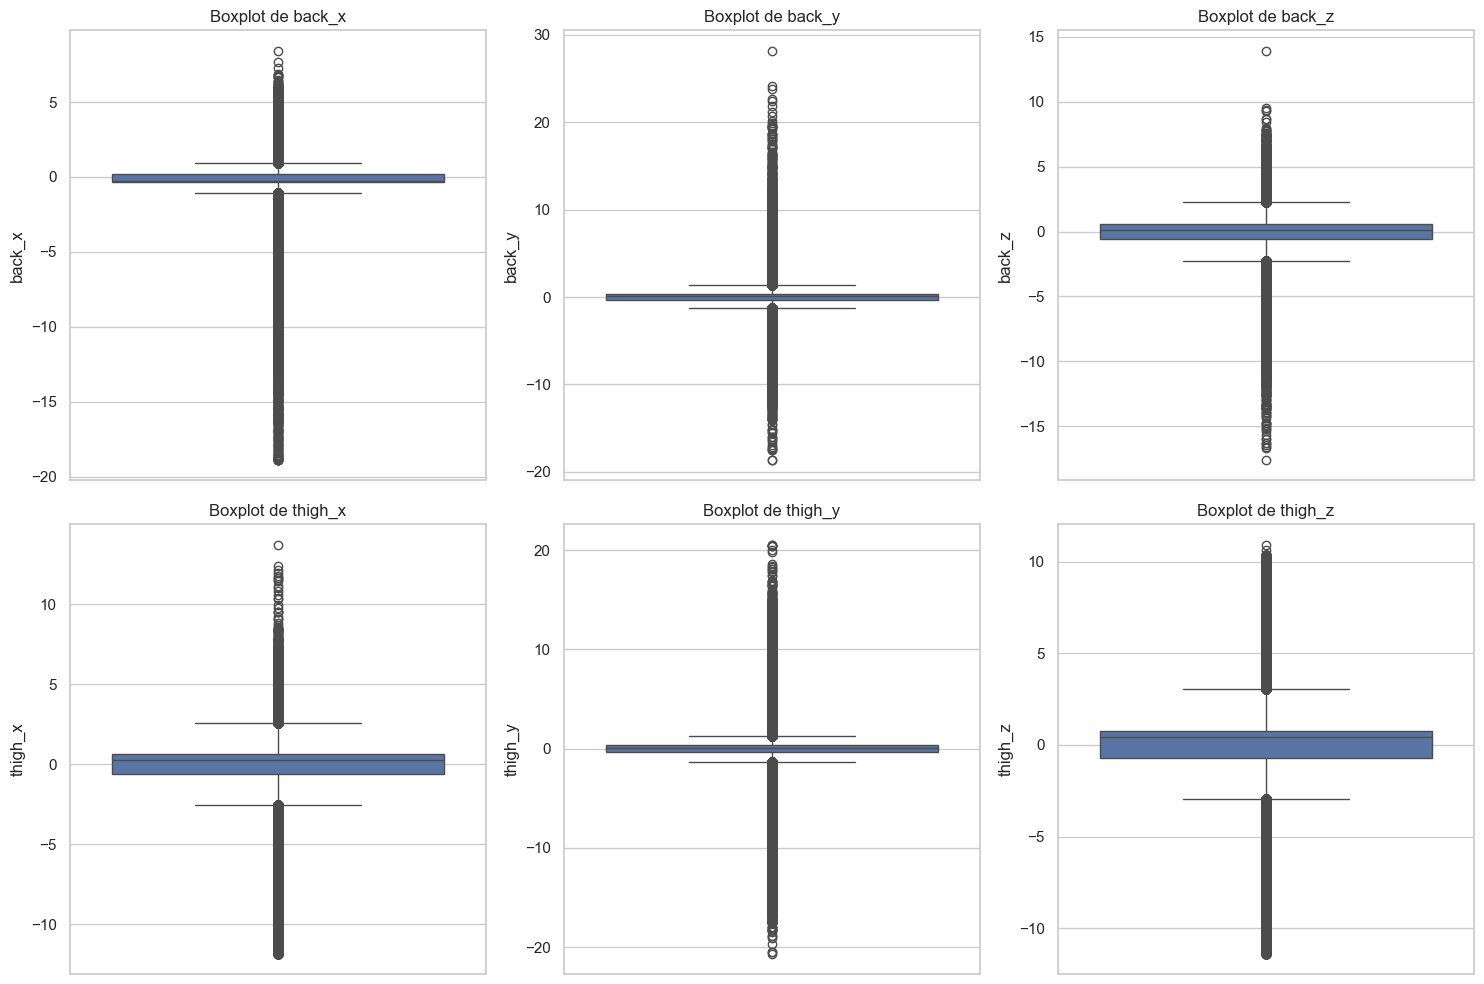

Número de outliers detectados por Z-Score: $507343$

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64
2019-01-12 00:00:00,0.330293,1.353248,1.749055,-7.181078,-0.822551,0.454455,6
2019-01-12 00:02:43.100,-1.210939,3.050026,0.711515,-0.653571,0.513943,-0.950917,1
2019-01-12 00:03:13.800,-0.919255,3.363959,0.687889,-0.64915,0.358385,-0.296835,1
2019-01-12 00:03:35.410,-1.474371,4.412604,1.671156,-1.148571,0.652607,-0.362975,1
2019-01-12 00:04:03.250,-0.886602,0.163189,1.250953,-3.329005,3.13183,-2.136228,1
…,…,…,…,…,…,…,…
2019-01-12 00:59:30.400,-1.652779,0.6604,-0.663487,-3.570954,-2.380443,0.808722,1
2019-01-12 00:59:30.420,-0.780554,1.381719,-1.068448,-3.534314,1.696624,-1.552426,1
2019-01-12 00:59:31.500,-0.461791,-0.048244,-0.160798,-4.045322,-2.165495,-4.413067,1


Número de outliers detectados por IQR: $1399305$

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64
2019-01-12 00:00:00,0.330293,1.353248,1.749055,-7.181078,-0.822551,0.454455,6
2019-01-12 00:00:00.030,0.625506,0.129082,0.315552,-1.531676,-2.501871,-0.809751,6
2019-01-12 00:00:00.040,1.403332,-0.166845,0.153423,0.075705,0.308988,-1.397501,6
2019-01-12 00:00:00.050,1.337504,-0.359878,0.398052,-0.569856,0.542315,-1.102051,6
2019-01-12 00:00:00.070,-2.238628,0.277729,0.513598,-1.314569,-0.263245,-0.586286,6
…,…,…,…,…,…,…,…
2019-01-12 00:59:55.340,-0.75469,0.538949,-0.425195,-1.462605,-2.305023,-1.132202,3
2019-01-12 00:59:55.360,-0.383556,0.968782,-0.41047,-1.005387,1.599206,-1.222416,3
2019-01-12 00:59:55.380,-0.118463,0.496703,-0.279943,-0.498276,1.42574,-0.844314,3


In [8]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
for i, col in enumerate(quantitative_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()

# Z-Score
z_scores = stats.zscore(df[quantitative_cols])
abs_z_scores = abs(z_scores)
outliers_z = (abs_z_scores > 3).any(axis=1)  # noqa: PLR2004

# Muestra las filas que son outliers
outlier_rows_z = df.filter(outliers_z)
display(
    Markdown(
        f"Número de outliers detectados por Z-Score: ${outlier_rows_z.shape[0]}$",
    ),
    outlier_rows_z,
)

# IQR (Rango Intercuartílico)
Q1 = df[quantitative_cols].quantile(0.25)
Q3 = df[quantitative_cols].quantile(0.75)
IQR = Q3 - Q1

# Define límites para detectar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Detecta outliers
outliers_iqr: list[bool] = (
    (df[quantitative_cols].to_numpy() < lower_bound.to_numpy())
    | (df[quantitative_cols].to_numpy() > upper_bound.to_numpy())
).any(axis=1)


# Muestra las filas que son outliers
outlier_rows_iqr = df.filter(outliers_iqr)
display(
    Markdown(
        f"Número de outliers detectados por IQR: ${outlier_rows_iqr.shape[0]}$"
    ),
    outlier_rows_iqr,
)

In [9]:
display(
    Markdown("Primeras filas del DataFrame preprocesado:"),
    df.head(),
    Markdown("Resumen estadístico del DataFrame preprocesado:"),
    df.describe(),
    Markdown("Información del DataFrame preprocesado:"),
    df.schema.to_frame(),
    Markdown(f"{df.estimated_size('mb')} MB"),
)

Primeras filas del DataFrame preprocesado:

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64
2019-01-12 00:00:00,0.330293,1.353248,1.749055,-7.181078,-0.822551,0.454455,6
2019-01-12 00:00:00.010,0.93969,1.276724,1.341687,2.387553,0.684944,-0.047014,6
2019-01-12 00:00:00.020,-0.757338,0.863492,0.006493,0.893189,-0.255631,-1.209252,6
2019-01-12 00:00:00.030,0.625506,0.129082,0.315552,-1.531676,-2.501871,-0.809751,6
2019-01-12 00:00:00.040,1.403332,-0.166845,0.153423,0.075705,0.308988,-1.397501,6


Resumen estadístico del DataFrame preprocesado:

statistic,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
str,str,f64,f64,f64,f64,f64,f64,f64
"""count""","""6461328""",6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6,6.461328e6
"""null_count""","""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""","""2012-02-20 18:20:58.805005""",-2.0081e-13,1.8051e-16,3.2458e-14,-2.7717e-15,1.1915e-14,-1.0838e-13,6.783833
"""std""",null,1.0,1.0,1.0,1.0,1.0,1.0,11.432381
"""min""","""2000-01-01 00:00:00""",-18.843224,-18.576544,-17.560763,-11.822707,-20.641445,-11.377443,1.0
"""25%""","""2000-01-01 01:23:47.680000""",-0.311011,-0.302234,-0.555719,-0.605612,-0.311401,-0.720868,3.0
"""50%""","""2019-01-12 00:12:46.760000""",-0.2382,0.068585,0.087534,0.276456,0.030255,0.442228,7.0
"""75%""","""2019-01-12 00:49:20.500000""",0.192415,0.37103,0.591797,0.681751,0.345152,0.779459,7.0
"""max""","""2019-01-12 02:23:36.720000""",8.412968,28.140243,13.924667,13.721867,20.540245,10.910662,140.0


Información del DataFrame preprocesado:

timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
datetime[μs],f64,f64,f64,f64,f64,f64,i64


394.3681640625 MB

In [10]:
# Aplicar PCA para reducir a 2 dimensiones
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df[quantitative_cols].to_arrow())
df = df.with_columns(
    [
        pl.Series("PC1", principal_components[:, 0]),
        pl.Series("PC2", principal_components[:, 1]),
    ]
)

df.columns

['timestamp',
 'back_x',
 'back_y',
 'back_z',
 'thigh_x',
 'thigh_y',
 'thigh_z',
 'label',
 'PC1',
 'PC2']

## **4. Descripción del conjunto de datos**


El conjunto de datos contiene registros de acelerómetros con mediciones en
diferentes ejes para la espalda (back_x, back_y, back_z) y el muslo (thigh_x,
thigh_y, thigh_z), junto con una etiqueta (label) que clasifica la actividad.

- Se identificaron 6,461,328 registros en total.

- Se realizó un análisis exploratorio, mostrando la media cercana a 0 tras
  normalización, lo que sugiere datos estandarizados.

- Se detectaron 507,343 valores atípicos usando Z-Score, indicando posibles
  variaciones extremas en la actividad.

- Se aplicó **PCA**(Análisis de Componentes Principales ) para reducir la
  dimensionalidad a 2 componentes principales, facilitando la visualización de
  patrones en los datos.


## **5. Análisis Exploratorio de Datos (EDA)**


Se realizará un análisis exploratorio de los datos obtenidos por acelerómetros
para identificar patrones, anomalías y relaciones entre variables mediante
histogramas y matrices de correlación. Este proceso optimizará la selección de
características y la normalización de los datos para aplicar clustering con
K-Means de manera efectiva.


### **5.1 Histogramas por Componente Espacial del Sensor**


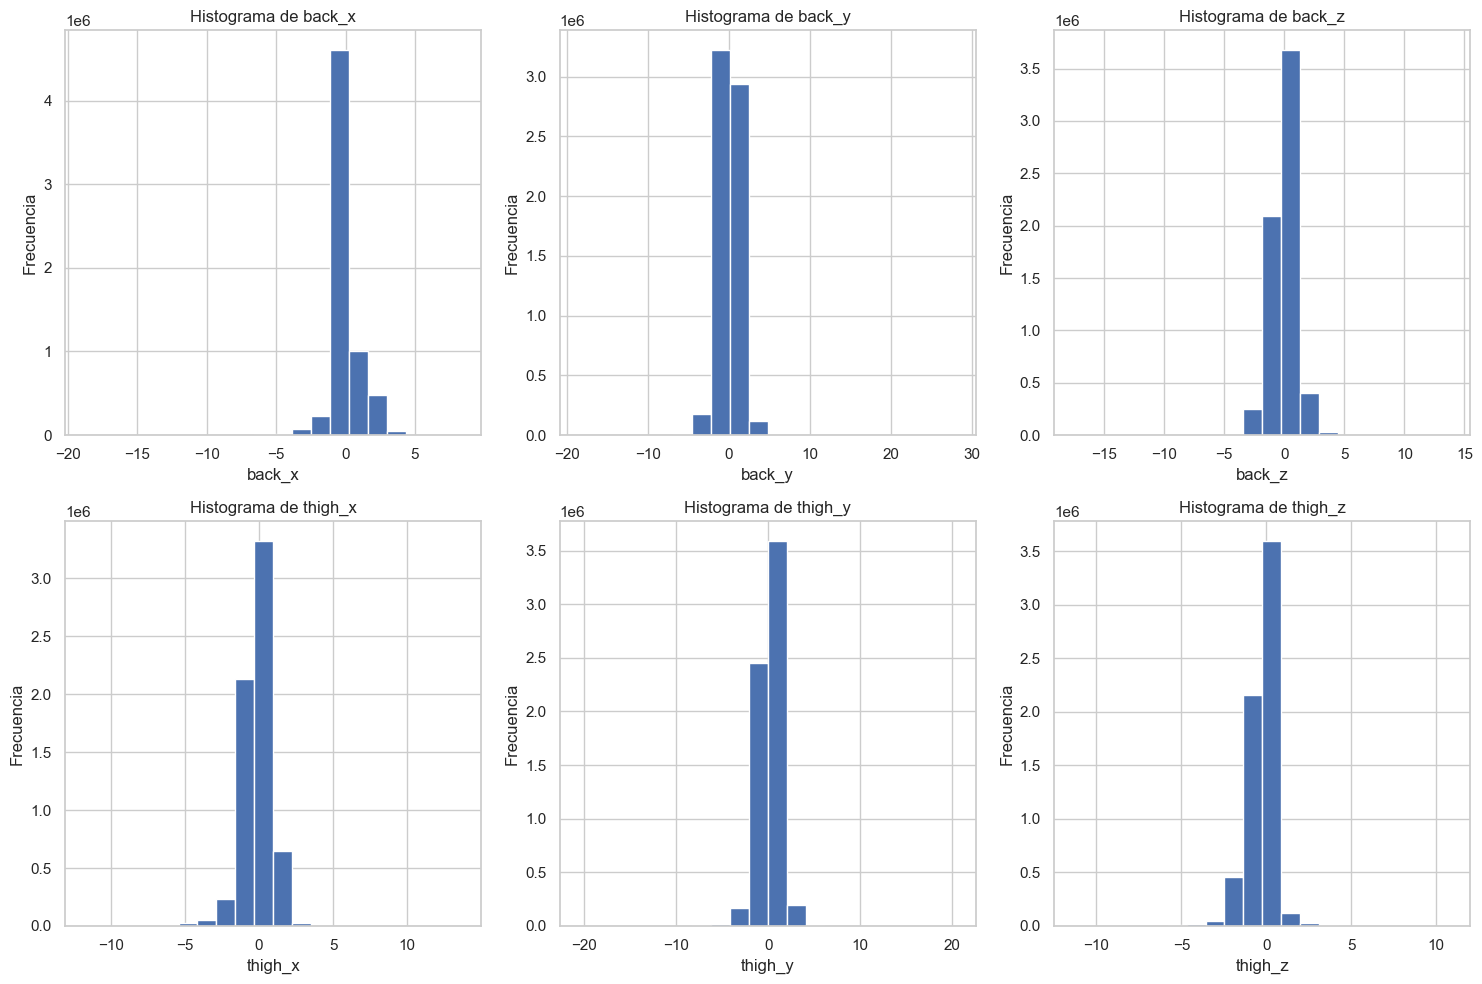

In [11]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(quantitative_cols):
    plt.subplot(2, 3, i + 1)
    plt.hist(df[col], bins=20)
    plt.title(f"Histograma de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### **5.2 Gráficas de Densidad KDE por Eje de Movimiento y Actividad**


In [ ]:
cols = 3
rows = math.ceil(len(quantitative_cols) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

axs = axs.flatten()

i = 0
for i, column in enumerate(quantitative_cols):
    sns.kdeplot(
        data=df,
        x=column,
        hue="label",
        fill=True,
        common_norm=False,
        alpha=0.5,
        ax=axs[i],
    )
    axs[i].set_title(f"Densidad de {column} según la actividad")

# Ocultar los gráficos vacíos
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### **5.3 Histograma de Frecuencia por Tipo de Actividad**


In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x="label", data=df)
plt.title("Distribución de Actividades")
plt.xlabel("Código de Actividad")
plt.ylabel("Cantidad de Muestras")
plt.show()

### **5.4 Matriz de Correlación**


In [ ]:
corr_matrix = df[quantitative_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matriz de Correlación de Datos del Acelerómetro")
plt.show()

### **5.5 Gráfico de Dispersión de Análisis de Componentes Principales (PCA)**


In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="label", data=df, palette="deep")
plt.title("PCA de Datos del Acelerómetro")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend(loc="upper right")
plt.show()

## **6. Aplicación de K-Means para Clustering**


El clustering es una técnica de aprendizaje no supervisado que se utiliza para
agrupar datos en función de sus características. En este caso, aplicaremos el
algoritmo K-Means para identificar patrones en los datos del acelerómetro. El
objetivo es agrupar las muestras en diferentes clústeres basados en las
características cuantitativas, lo que puede ayudarnos a entender mejor las
diferentes actividades representadas en el conjunto de datos.


### **6.1 Mapeo de etiquetas de actividad, filtrado y muestreo del dataset para análisis posterior**


In [ ]:
# Mapear etiquetas a nombres usando Polars
label_mapping = {
    1: "walking",
    2: "running",
    3: "shuffling",
    4: "stairs_up",
    5: "stairs_down",
    6: "standing",
    7: "sitting",
    8: "lying",
    13: "cycling_sit",
    14: "cycling_stand",
    130: "cycling_sit_inactive",
    140: "cycling_stand_inactive",
}

# Agregar columna de actividad usando Polars, asegurando que sea str
df = df.with_columns(
    pl.col("label")
    .map_elements(
        lambda x: label_mapping.get(x, "unknown"), return_dtype=pl.Utf8
    )
    .alias("activity")
)

# Reducimos la cantidad de filas a solo una centésima parte
size = df.shape[0] // 100
df = df.drop_nulls(subset=["activity"]).sample(n=size, seed=42)

# Seleccionar variables para el modelo
features = ["back_x", "back_y", "back_z", "thigh_x", "thigh_y", "thigh_z"]


x = df[features].to_numpy()
y = df["activity"].to_numpy()

### **6.2 Normalización de características y determinación del número óptimo de clústeres con el Método del Codo**


In [ ]:
# Normalización
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:
# MÉTODO DEL CODO
inertia = []
k_range = range(1, 6)  # ✅ menor rango, más rápido

for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    kmeans.fit(x_scaled)
    inertia.append(kmeans.inertia_)

# Gráfica del Codo
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, "bo-")
plt.xlabel("Número de Clústeres (K)")
plt.ylabel("Inercia")
plt.title("Método del Codo")
plt.grid(visible=True)
plt.show()

El número óptimo de clústeres es K = 3 porque es donde la curva del gráfico
forma un “codo”. Esto significa que con tres clústeres se logra una buena
separación de los datos, y añadir más ya no mejora mucho el resultado.


### **6.3 método del coeficiente de silueta**


In [ ]:
# Rango de K
k_range = range(2, 6)

# Lista para almacenar los scores
silhouette_scores = []

# Calcular score de silueta para cada K
for k in k_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    labels = kmeans.fit_predict(x_scaled)
    score = silhouette_score(x_scaled, labels)
    silhouette_scores.append(score)

# Graficar resultados
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, "go-")
plt.xlabel("Número de Clústeres (K)")
plt.ylabel("Coeficiente de Silueta")
plt.title("Método del Coeficiente de Silueta")
plt.grid(visible=True)
plt.show()

La gráfica del coeficiente de silueta muestra que K = 2 tiene la mejor
separación entre clústeres, ya que alcanza el valor más alto. Aunque el método
del codo sugiere K = 3 como un buen punto, la silueta indica que agrupar en dos
clústeres da resultados más claros.


### **6.4 Clustering final con K óptimo y asignación de clusters al dataframe**


In [ ]:
# Clustering final con K óptimo
optimal_k = 3
kmeans_final = MiniBatchKMeans(
    n_clusters=optimal_k, random_state=42, batch_size=1024
)
clusters = kmeans_final.fit_predict(x_scaled)

# Asignar cluster a la muestra, no al dataframe completo
df = df.with_columns([pl.Series("cluster", clusters)])

In [ ]:
# Visualización PCA de los clusters
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=clusters, cmap="viridis", alpha=0.6)
plt.title(f"Clusters KMeans con PCA ($K={optimal_k}$)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label="Cluster")
plt.grid(visible=True)
plt.show()

## **7. Clasificación con MLP (Perceptrón Multicapa)**


In [ ]:
# Asegurarse de que y viene del mismo conjunto que X_scaled
y = df["activity"].to_numpy()

### **7.1 Análisis de Outliers y Distribución de Características**


In [ ]:
# Revisar visualmente los outliers en las características
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[features])
plt.title("Boxplot de características para detectar valores atípicos")
plt.xticks(rotation=45)
plt.grid(visible=True)
plt.show()

In [ ]:
# Clasificación con datos actuales (con outliers)
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42
)

#### Configuración y entrenamiento del modelo MLP

Creamos un perceptrón multicapa con:

- Dos capas ocultas (64 y 32 neuronas respectivamente).
- Función de activación ReLU.
- Optimizador Adam.
- Máximo 200 iteraciones.


In [ ]:
mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Arquitectura de la red
    activation="relu",  # Función de activación
    solver="adam",  # Algoritmo de optimización
    max_iter=200,  # Máximo de iteraciones
    random_state=42,  # Semilla para reproducibilidad
)

### **7.2 Predicción y evaluación**


In [ ]:
# Entrenamiento y evaluación con outliers
mlp.fit(X_train_o, y_train_o)
y_pred_o = mlp.predict(X_test_o)
acc_original = accuracy_score(y_test_o, y_pred_o)

In [ ]:
# Quitar outliers usando Z-score (versión corregida para Polars)
z_scores = np.abs(zscore(df[features]))
filtered_entries = (z_scores < 3).all(axis=1)

# Usar el método filter() de Polars en lugar de indexación booleana
data_no_outliers = df.filter(filtered_entries)  # Corrección clave aquí

# Re-calcular datos
X_clean = scaler.fit_transform(data_no_outliers[features].to_numpy())
y_clean = data_no_outliers["activity"]

# Calculate accuracy for the model without outliers
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)
mlp_clean = MLPClassifier(
    hidden_layer_sizes=(64, 32),  # Arquitectura de la red
    activation="relu",  # Función de activación
    solver="adam",  # Algoritmo de optimización
    max_iter=200,  # Máximo de iteraciones
    random_state=42,  # Semilla para reproducibilidad
)
mlp_clean.fit(X_train_clean, y_train_clean)
y_pred_clean = mlp_clean.predict(X_test_clean)
acc_clean = accuracy_score(y_test_clean, y_pred_clean)

In [ ]:
# Resultados comparativos
display(
    Markdown(f"""
### Resultados Comparativos:
- **Accuracy con outliers:** {acc_original:.4f}
- **Accuracy sin outliers:** {acc_clean:.4f}
""")
)

In [ ]:
# Recomendación basada en los resultados
if acc_clean > acc_original:
    display(
        Markdown("""
    **Conclusión:** Los valores atípicos afectan negativamente al modelo.
    Se recomienda usar los datos limpios para el modelado final.""")
    )
    x_scaled, y = X_clean, y_clean  # Usamos datos limpios
else:
    display(
        Markdown("""
    **Conclusión:** Los valores atípicos no tienen impacto negativo.
    Se mantienen los datos originales.""")
    )
    # x_scaled e y ya están definidos

### **7.3 Modelado Final (Con la mejor opción)**


In [ ]:
display(Markdown("\n## Entrenamiento del Modelo Final"))

# Redefinimos los datos de entrenamiento/prueba con la mejor opción
x_train, x_test, y_train, y_test = train_test_split(
    x_scaled, y, test_size=0.2, random_state=42
)

# Reinstanciamos el modelo para evitar contaminación
mlp_final = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    solver="adam",
    max_iter=200,
    random_state=42,
)

# Entrenamiento y evaluación final
mlp_final.fit(x_train, y_train)
y_pred = mlp_final.predict(x_test)

# Métricas finales
display(Markdown("### Resultados de Evaluación Final"))

display(
    Markdown("""
A continuación, se muestran resultados de evaluación:
1. Reporte de clasificación (métricas de evaluación)
2. Métricas adicionales resumidas
""")
)

# Reporte de clasificación completo
display(Markdown("#### Informe de Clasificación Detallado:"))
print(classification_report(y_test, y_pred, digits=4))

# Métricas resumidas en tabla
display(Markdown("#### Métricas Principales:"))
metrics_df = pd.DataFrame(
    {
        "Métrica": [
            "Accuracy",
            "Precision (promedio)",
            "Recall (promedio)",
            "F1-score (promedio)",
        ],
        "Valor": [
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred, average="weighted"),
            recall_score(y_test, y_pred, average="weighted"),
            f1_score(y_test, y_pred, average="weighted"),
        ],
    }
)
display(metrics_df.round(4))

#### **7.3.1 Matriz de confusión: ¿Qué patrones acierta o falla el modelo?**


In [ ]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mlp.classes_)
disp.plot(cmap="viridis", xticks_rotation=45)
plt.title("Matriz de Confusión - MLP")
plt.grid(visible=False)
plt.show()

#### **7.3.2 Análisis de importancia de características (permutación)**

Esto te dice qué variables son más relevantes para predecir una actividad:


In [ ]:
result = permutation_importance(
    mlp, x_test, y_test, n_repeats=10, random_state=42
)
importances = result.importances_mean
feature_names = features  # Usa tu lista de nombres de columnas

# Graficar importancia de cada característica
plt.figure(figsize=(10, 5))
plt.barh(feature_names, importances)
plt.xlabel("Importancia Media")
plt.title("Importancia de características para predicción de actividad")
plt.grid(visible=True)
plt.tight_layout()
plt.show()

In [ ]:
build_path = Path("..", "build")

if build_path.exists():
    remove_file_or_directory(build_path)

build_path.mkdir(parents=True, exist_ok=True)

joblib.dump(mlp, build_path / "mlp_model.pkl")
None

## **Interpretación de resultados**


**Rendimiento General del Modelo**

El modelo **MLP (Perceptrón Multicapa)** muestra un rendimiento general sólido
con una precisión del **87%**. Esto indica que de cada 100 predicciones,
aproximadamente 87 son correctas, lo cual es un resultado satisfactorio para la
clasificación de actividades humanas.

**Análisis por Actividades**

- Actividades con Excelente Rendimiento:

  - Lying (acostado): 99.5% de precisión - El modelo identifica casi
    perfectamente cuando una persona está acostada.

  - Sitting (sentado): 99.3% de precisión - Igualmente exitoso para detectar la
    posición sentada. Estas actividades probablemente tienen patrones de
    movimiento muy distintivos que facilitan su clasificación.

- Actividades con Buen Rendimiento:

  - Running (corriendo): 89.7% de precisión - Buena identificación de la
    actividad de correr.

  - Cycling_sit (ciclismo sentado): 74.5% de precisión - Rendimiento aceptable.

- Walking (caminando): 75.8% de precisión - Clasificación razonable de la
  caminata.
- Standing (de pie): 71.1% de precisión - Detección moderada de la posición de
  pie.

- Actividades con Dificultades:

- Stairs_down (bajar escaleras): Solo 25% de precisión - El modelo tiene serias
  dificultades.

- Stairs_up (subir escaleras): 28.6% de precisión - Igualmente problemático
  Shuffling (arrastrando pies): 41% de precisión - Clasificación deficiente.
- Cycling_stand_inactive: 45.5% de precisión - Problemas con estados inactivos.

- Importancia de las Características:

  Según el gráfico de importancia de características :

- thigh_z y thigh_x: Son las características más importantes, sugiriendo que los
  movimientos del muslo en los ejes Z y X son cruciales para distinguir
  actividades.

- back_x: También muy relevante, indicando que los movimientos del torso son
  informativos.

- back_z: Moderadamente importante.

- thigh_y y back_y: Menos influyentes en la clasificación.

- Desafíos Identificados:

  - Confusión entre Actividades Similares:

    - El modelo confunde actividades con patrones de movimiento parecidos como
      subir y bajar escaleras que, son particularmente difíciles de distinguir.

    - Las actividades "inactivas" presentan desafíos especiales.

- Desequilibrio de Datos:

- Algunas actividades como "stairs_down" (129 muestras) y
  "cycling_stand_inactive" (20 muestras) tienen muy pocas observaciones. Esto
  explica parcialmente el bajo rendimiento en estas categorías.
